In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
import torch

In [3]:
from utils import MnistData
from models import ModelManager, ModelType

In [51]:
model_loaded = ModelManager.get_trained(ModelType.MnistCnnPatt)


In [5]:
data = MnistData(True)

In [6]:
def max_norm(t: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.abs(t))

In [81]:
def solve_for(model, benign_image, label, c_lambda):
    step_size = 1e-2
    #adv = benign_image + (torch.rand(benign_image.shape) - 0.5) * 1e-1
    #adv = benign_image
    adv = torch.zeros(benign_image.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    norm = nn.L1Loss(reduction='sum')
    for _ in range(100):
        adv.requires_grad = True
        if adv.grad is not None:
            adv.grad.zero_()
        loss = norm(adv.unsqueeze(0), benign_image.unsqueeze(0)) \
            - c_lambda * loss_fn(model(adv.unsqueeze(0)), torch.Tensor([label]).type(torch.long))
        loss.backward()
        new_adv = MnistData.clip_for_image(adv - step_size * adv.grad.apply_(lambda x: 1 if x >= 0 else -1))
        adv = new_adv
    if MnistData.get_prediction(model, adv)[0] != label:
        return adv
    return None
    


In [73]:
def cw_attack(model, benign_image, label) -> torch.Tensor:
    adv = None
    c_lambda = 1e-1
    while adv is None:
        #print(f'\tc_lamda = {c_lambda}')
        adv = solve_for(model, benign_image, label, c_lambda)
        c_lambda *= 1.1
    #print(f'\tc_lamda = {c_lambda}')
    return adv
        


In [82]:
benign_images, labels = data.get_training_batch(100)
altered_training_images = []

for i in range(len(labels)):
    print(f'--- {i} ---')
    benign_image = benign_images[i]
    #MnistData.display(benign_image)
    label = labels[i]
    altered_training_images.append(cw_attack(model_loaded, benign_image, label))

#altered_training_images = torch.Tensor(altered_training_images)

--- 0 ---
	c_lamda = 0.1948717100000001
--- 1 ---
	c_lamda = 1.1918176537727232
--- 2 ---
	c_lamda = 0.6115909044841462
--- 3 ---
	c_lamda = 1.1918176537727232
--- 4 ---
	c_lamda = 0.41772481694156544
--- 5 ---
	c_lamda = 0.41772481694156544
--- 6 ---
	c_lamda = 0.5559917313492238
--- 7 ---
	c_lamda = 0.740024994425817
--- 8 ---
	c_lamda = 1.0834705943388392
--- 9 ---
	c_lamda = 1.1918176537727232
--- 10 ---
	c_lamda = 0.8954302432552388
--- 11 ---
	c_lamda = 0.17715610000000007
--- 12 ---
	c_lamda = 0.8954302432552388
--- 13 ---
	c_lamda = 0.5054470284992942
--- 14 ---
	c_lamda = 0.740024994425817
--- 15 ---
	c_lamda = 0.17715610000000007
--- 16 ---
	c_lamda = 0.11000000000000001
--- 17 ---
	c_lamda = 0.5559917313492238
--- 18 ---
	c_lamda = 1.0834705943388392
--- 19 ---
	c_lamda = 0.8954302432552388
--- 20 ---
	c_lamda = 0.1948717100000001
--- 21 ---
	c_lamda = 0.37974983358324127
--- 22 ---
	c_lamda = 1.1918176537727232
--- 23 ---
	c_lamda = 1.4420993610649953
--- 24 ---
	c_lamda = 

In [83]:
possible_adversarials = MnistData.get_adversarials(model_loaded, benign_images, labels, altered_training_images)
len(possible_adversarials)

99

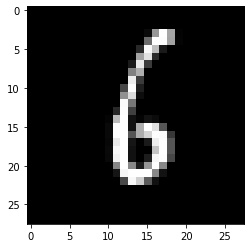

+++++


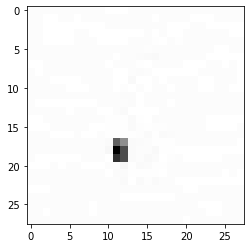

=====


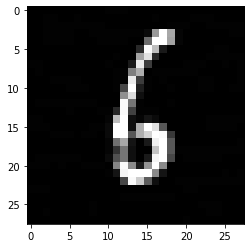

Label: 6, Prediction: 5, Confidence: 0.9927910566329956
Original prediction: 6, Original confidence: 1.0


In [86]:
MnistData.show_adversarial(possible_adversarials, benign_images, altered_training_images, 97)

In [88]:
import numpy as np
from matplotlib import pyplot as plt

C:\Users\stani\AppData\Local\Temp/ipykernel_29604/3977462011.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"AEXAMPLES\\CW\\ALTERED\\cw_altered_{counter}.png", bbox_inches="tight", pad_inches=0, pad_width=0)
C:\Users\stani\AppData\Local\Temp/ipykernel_29604/3977462011.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"AEXAMPLES\\CW\\BENIGN\\cw_benign_{counter}.png", bbox_inches="tight", pad_inches=0, pad_width=0)


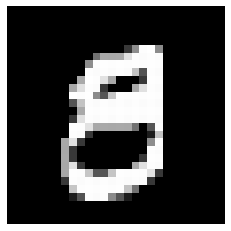

In [89]:
counter = 0
for adversarial in possible_adversarials:
    index = adversarial['Index']
    aexample = altered_training_images[index]
    aexample = np.array(aexample * 255)
    plt.imshow(aexample.reshape(28, 28), cmap='gray')
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW\\ALTERED\\cw_altered_{counter}.png", bbox_inches="tight", pad_inches=0, pad_width=0)
    bexample = benign_images[index]
    bexample = np.array(bexample * 255)
    plt.imshow(bexample.reshape(28, 28), cmap='gray')
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW\\BENIGN\\cw_benign_{counter}.png", bbox_inches="tight", pad_inches=0, pad_width=0)
    counter += 1
